# Optimisation: Using Transformed Parameters

This example shows you how to run a global optimisation with a transformed parameter space.


First we will create a toy model which implements the logistic model.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl
import math

model = toy.LogisticModel()

The parameters for the toy logistic model are $[r, K]$, where $r$ is the rate and $K$ is the carrying capacity. We will create a wrapper pints model that assumes that the parameters are given as $(r, \log(K)]$

In [2]:
class TransformedModel(pints.ForwardModel):
    def __init__(self, model):
        self._model = model
    def dimension(self):
        return self._model.dimension()
    def simulate(self, parameters, times):
        transformed_parameters = [parameters[0], math.exp(parameters[1])]
        return self._model.simulate(transformed_parameters,times)

transformed_model = TransformedModel(model)

Now that we have our transformed model, we can use it in combination with all of pints' optimisation and inference algorithms. For now, we will use it to fit simulated data using CMA-ES:

Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
0: 34593168.8587
1: 34554342.7334
2: 34554342.7334
3: 34554342.7334
20: 15733784.016
40: 101979.143186
60: 91265.9864561
80: 91264.4765664
100: 91264.4764194
120: 91264.4764194
140: 91264.4764194
160: 91264.4764194
180: 91264.4764194
200: 91264.4764194
220: 91264.4764194
240: 91264.4764194
260: 91264.4764194
280: 91264.4764194
300: 91264.4764194
320: 91264.4764194
340: 91264.4764194
360: 91264.4764194
380: 91264.4764194
400: 91264.4764194
420: 91264.4764194
440: 91264.4764194
460: 91264.4764194
480: 91264.4764194
Halting: No significant change for 200 iterations.
492: 91264.4764194
Score at true solution: 
91268.1715706
Found solution:          True parameters:
 1.49998256485711148e-02     1.49999999999999994e-02
 6.00021127616998839e+00     6.00000000000000000e+00


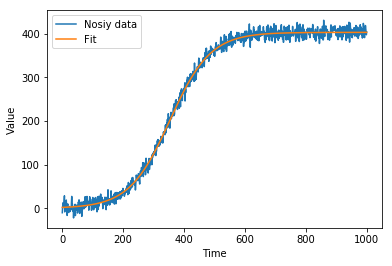

In [3]:
# Create some toy data
real_parameters = [0.015, 6]
times = np.linspace(0, 1000, 1000)
values = transformed_model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(transformed_model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.Boundaries([0, -6.0], [0.03, 20.0])

# Perform an optimization with boundaries and hints
x0 = 0.01,5.0
sigma0 = [0.01, 2.0]
found_parameters, found_value = pints.optimise(
    score,
    x0,
    sigma0,
    boundaries,
    method=pints.CMAES,
)

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

# Show quality of fit
pl.figure()
pl.xlabel('Time')
pl.ylabel('Value')
pl.plot(times, values, label='Nosiy data')
pl.plot(times, problem.evaluate(found_parameters), label='Fit')
pl.legend()
pl.show()